<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; padding: 30px 30px 0px 30px;">Design an application for public health - Project 3</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;">
    <span style="width: 100%; text-align: center; font-size:20px; font-weight: bold; float: left;">| Analysis notebook |</span>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <span style="width: 100%; text-align: center; font-size:26px; float: left;">Data Scientist course - OpenClassrooms</span>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
    <li>JupyterLab 3.0.14</li>
    <li>JupyterLab Theme: JupyterLab Dark</li>
    <li>Extension: @jupyter-widgets/jupyterlab-manager</li>
</ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [92]:
import os
import io
import gc
import itertools
from math import prod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline
sns.set_theme(style="darkgrid")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [93]:
def df_analysis(df, name_df, columns, *args, **kwargs):
    """
    Method used for analyzing on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        columns (list): Dataframe keys in list format
        
        *args, **kwargs:
        -----------------
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    flag = kwargs.get("flag", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
            print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        pd.set_option("display.max_rows", None) # show full of showing rows
        pd.set_option("display.max_columns", None) # show full of showing cols
        pd.set_option("max_colwidth", None) # show full width of showing cols
        
        if flag is None or flag != "complete":
            print("\n- Type object and records by columns   (",memory_usage,")")
            print("--------------------------------------------------------------------")
        elif flag == "complete":
            df_resume["unique"] = list(df.nunique())
            df_desc = pd.DataFrame(df.describe().T).reset_index()
            df_desc = df_desc.rename(columns={"index": "name"})
            df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
            df_resume = df_resume[ORDERING_COMPLETE]
            print("\n- Type object and records by columns                                                                   (",memory_usage,")")
            print("---------------------------------------------------------------------------------------------------------------------------------")
        
        display(df_resume.sort_values("records", ascending=False))
        
        pd.reset_option("display.max_rows") # reset max of showing rows
        pd.reset_option("display.max_columns") # reset max of showing cols
        pd.reset_option("display.max_colwidth") # reset width of showing cols
        
        # deleting dataframe to free memory
        if flag == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

In [94]:
data = pd.read_csv("datasets\dataset_to_analyse.csv")

In [95]:
data.head(5)

,code,last_modified_datetime,product_name,main_category,categories,renamed_category,image_url,energy-kcal_100g,fat_100g,carbohydrates_100g,saturated-fat_100g,sugars_100g,proteins_100g,salt_100g,nutriscore_score,nutriscore_grade
0,0000000005166,2019-02-12 18:38:12,cuisse de poulet direct au four curry,en:chicken-thighs,"Viandes, Volailles, Poulets, Cuisses de poulet",Meats,https://static.openfoodfacts.org/images/produc...,197.0,13.0,3.0,4.0,0.90,17.0,1.10,4.0,c
1,0000069163036,2019-02-12 18:38:13,Cuisses de poulet,en:chicken-thighs,"Viandes, Volailles, Poulets, Cuisses de poulet",Meats,https://static.openfoodfacts.org/images/produc...,206.0,15.0,1.7,4.2,1.70,16.0,1.10,5.0,c
2,0000130008136,2019-01-04 20:45:08,Escalope de dinde,en:turkey-cutlets,"Viandes, Volailles, Dindes, Escalopes de dinde",Meats,NaN,151.2,5.8,0.1,1.4,0.02,24.0,1.40,3.0,NaN
3,00003001,2020-10-28 15:20:28,Filet de poulet extra tendre thym citron,en:chicken-breasts,"Viandes, Volailles, Poulets, Filets de poulet",Meats,https://static.openfoodfacts.org/images/produc...,108.0,1.6,1.6,0.0,0.70,22.0,1.30,1.0,b
4,650403,2020-05-04 15:38:15,2 roast chicken legs,en:chicken-thighs,"Viandes, Volailles, Poulets, Cuisses de poulet",Meats,https://static.openfoodfacts.org/images/produc...,219.0,13.4,0.3,3.4,0.30,24.4,0.58,2.0,b


In [96]:
df_analysis(data, "data", "code", flag="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  16416 rows and 16 columns
- Total of NaN values:            4476
- Percentage of NaN:              1.7 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 2.0+ MB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,16416,16416,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,object,16416,12255,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,main_category,object,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,categories,object,16416,9,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renamed_category,object,16416,6,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,energy-kcal_100g,float64,16416,1140,0,0.00,353.021904,0.0,151.000,287.0,510.000000,989.0,254.292748
8,fat_100g,float64,16416,863,0,0.00,26.286152,0.0,5.800,14.0,35.000000,100.0,29.898740
9,carbohydrates_100g,float64,16416,908,0,0.00,11.918009,0.0,0.000,0.5,2.700000,91.0,22.622304
10,saturated-fat_100g,float64,16416,738,0,0.00,9.315327,0.0,1.400,3.8,16.824999,39.0,9.377998
11,sugars_100g,float64,16416,682,0,0.00,6.565565,0.0,0.000,0.3,1.200000,67.5,12.840380


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Initial analysis</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Nutri Score grade in subset</h3>
</div>

In [97]:
data_piechart = data["nutriscore_grade"].value_counts().values
labels_piechart = ["A", "B", "C", "D", "E"]
textprops = dict(size=16, color="blue", backgroundcolor="white")
colors = dict(A="#038141", B="#85BB2F", C="#FECB02", D="#EE8100", E="#E63E11")
explode = (0.02, 0, 0, 0, 0)

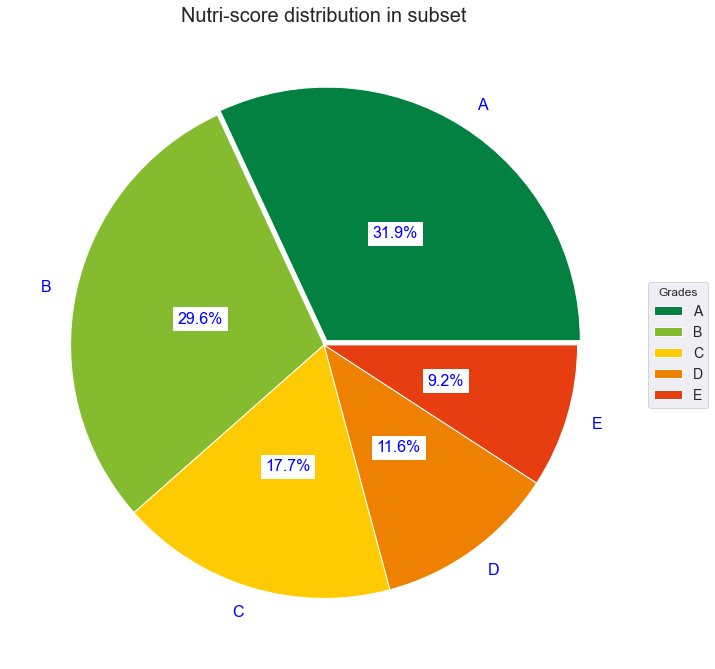

In [98]:
pie, ax = plt.subplots(figsize=[10,10])
plt.title("Nutri-score distribution in subset", size=20)
plt.pie(x=data_piechart, labels=labels_piechart, explode=explode, autopct="%1.1f%%", pctdistance=0.5, 
        textprops=textprops, colors=[colors[key] for key in labels_piechart], startangle=0)
ax.legend(labels_piechart, title="Grades", loc="center left", fontsize=14, bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.savefig("img/nutri-score-distribution.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Comparison of the variables in each category</h3>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to work following the next premises
    <ul style="list-style-type: square;">
        <li><b>Select only 4 variables independent to work</b></li>
        <ul style="list-style-type: disc;">
            <li>energy-kcal_100g</li>
            <li>proteins_100g</li>
            <li>fat_100g</li>
            <li>sugars_100g</li>
        </ul>
        <li>We also consider the variable dependent <b>Nutri-Score</b></li>
    </ul>
</div>

In [99]:
VARIABLES = {
    "energy-kcal_100g":"Energy", "proteins_100g":"Proteins", "fat_100g":"Fat", "sugars_100g":"Sugars", "nutriscore_score":"Nutri-Score"
}

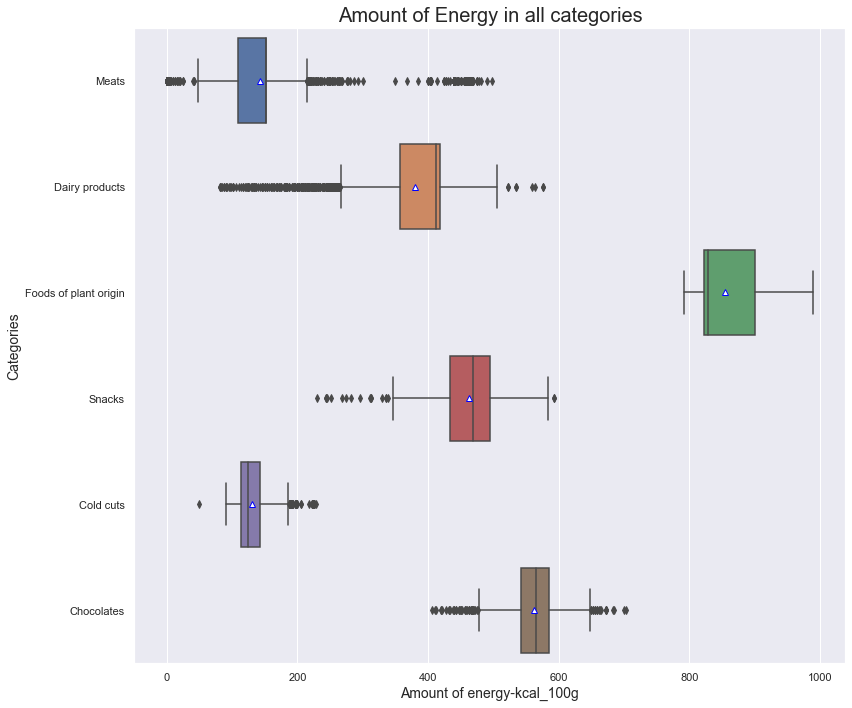

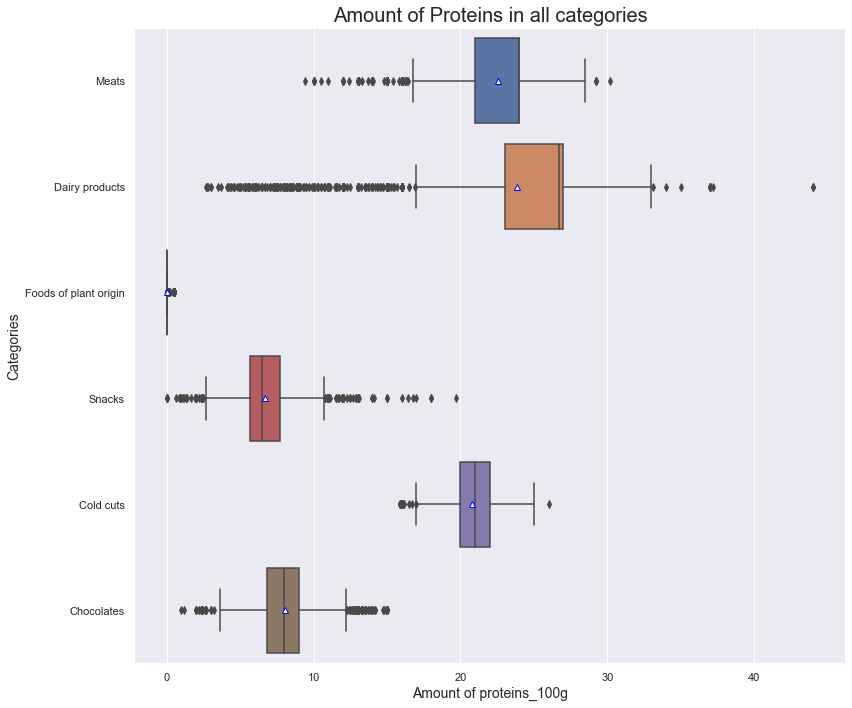

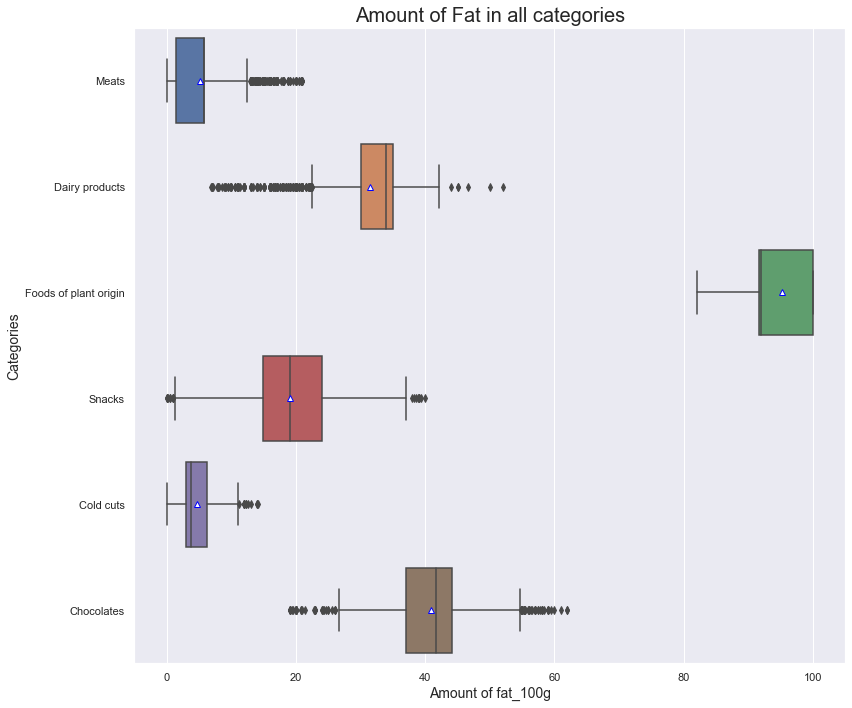

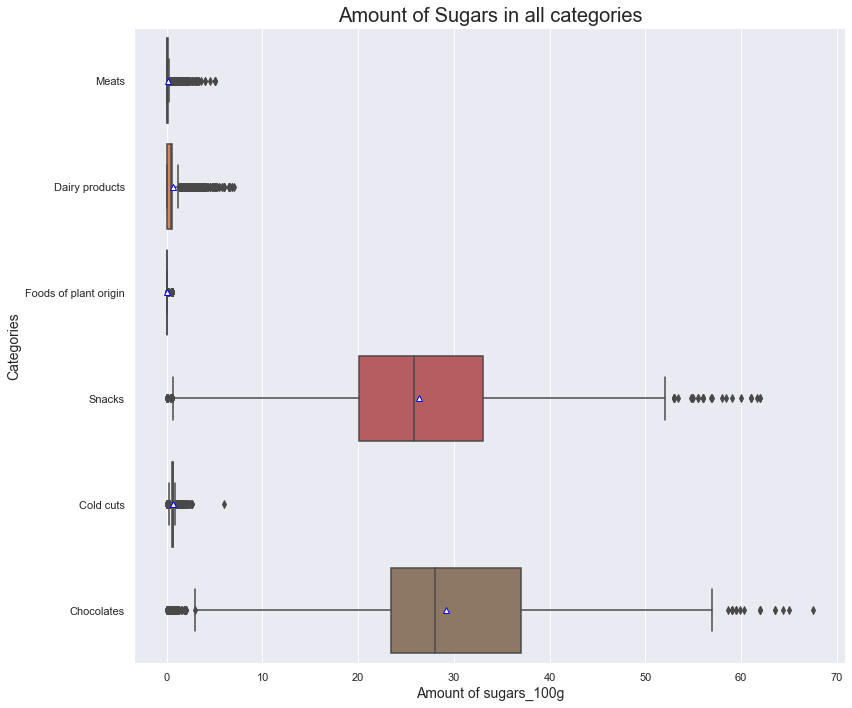

In [100]:
for var in VARIABLES:
    if var != "nutriscore_score":
        plt.figure(figsize=[12,10])
        sns.boxplot(x=data[var], y=data["renamed_category"], orient="h", showmeans=True, 
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        plt.title("Amount of " + VARIABLES.get(var) + " in all categories", size=20)
        plt.ylabel("Categories", size=14)
        plt.xlabel("Amount of " + var, size=14)
        plt.tight_layout()
        plt.savefig("img/comparison-of-" + VARIABLES.get(var) + "-in-each-category.png")
        plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.3. Select a subset of data</h3>
</div>

<div class="alert alert-block alert-info">
    To limit the analysis to be performed, we are going to <b>work only with one category</b>
</div>

In [117]:
data.groupby("renamed_category")["code"].count().sort_values(ascending=False)

renamed_category
Meats                    6141
Dairy products           2469
Foods of plant origin    2125
Snacks                   1936
Cold cuts                1934
Chocolates               1811
Name: code, dtype: int64

In [118]:
df_subset = data[data["renamed_category"] == "Snacks"].copy()

In [119]:
df_subset.shape

(1936, 16)

In [120]:
df_analysis(df_subset, "df_subset", "code", flag="complete")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  1936 rows and 16 columns
- Total of NaN values:            264
- Percentage of NaN:              0.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): code is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns                                                                   ( memory usage: 257.1+ KB )
---------------------------------------------------------------------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,code,object,1936,1936,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,last_modified_datetime,object,1936,1902,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,main_category,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,categories,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,renamed_category,object,1936,1,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,energy-kcal_100g,float64,1936,380,0,0.00,463.275483,230.0,433.000,468.00,495.000000,593.000000,45.314214
8,fat_100g,float64,1936,328,0,0.00,19.109066,0.0,14.840,19.00,24.000000,40.000000,6.803020
9,carbohydrates_100g,float64,1936,374,0,0.00,64.395341,28.9,60.000,65.00,70.300003,91.000000,8.434375
10,saturated-fat_100g,float64,1936,275,0,0.00,8.634710,0.0,3.775,7.90,13.000000,26.000000,5.675293
11,sugars_100g,float64,1936,411,0,0.00,26.355495,0.0,20.040,25.85,33.000000,62.000000,10.892756


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Bivariate analysis</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4.1. correlation between variables</h3>
</div>

<div class="alert alert-block alert-info">
    <b>Linear regression</b> through <b>Pearson</b>
</div>

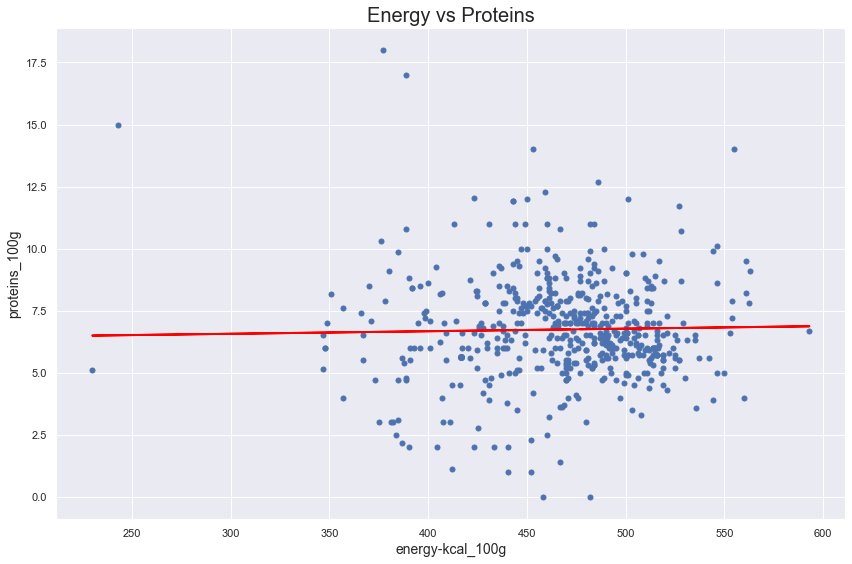

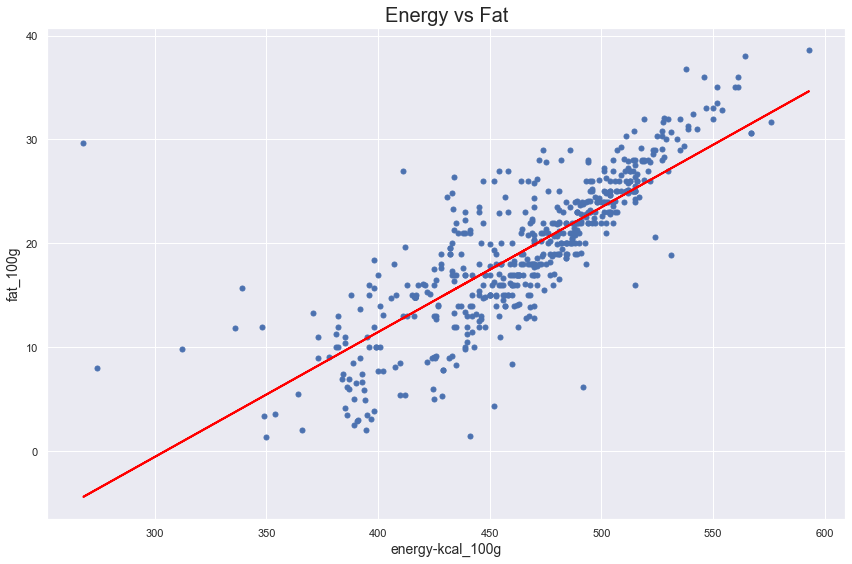

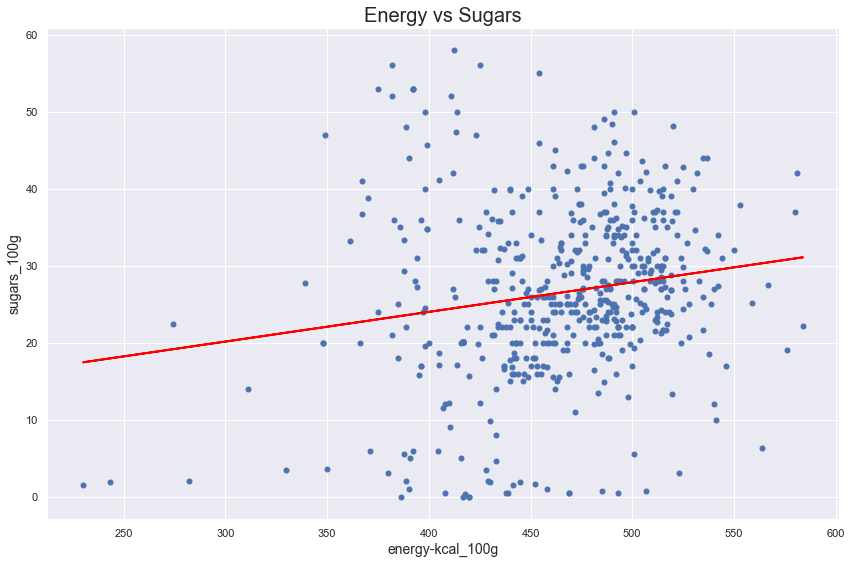

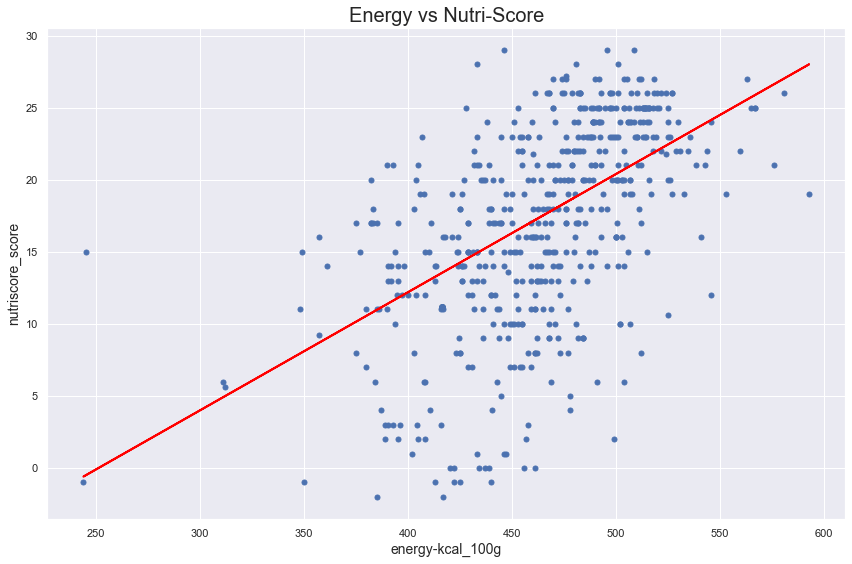

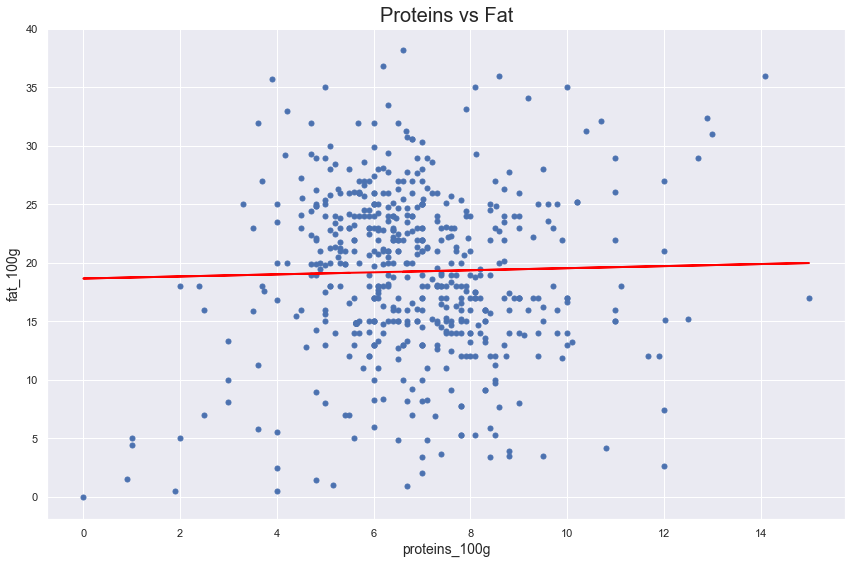

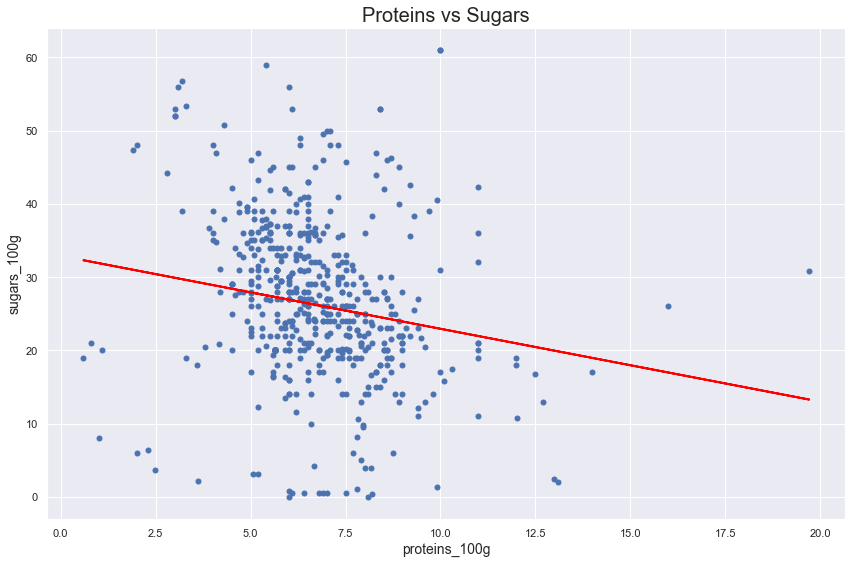

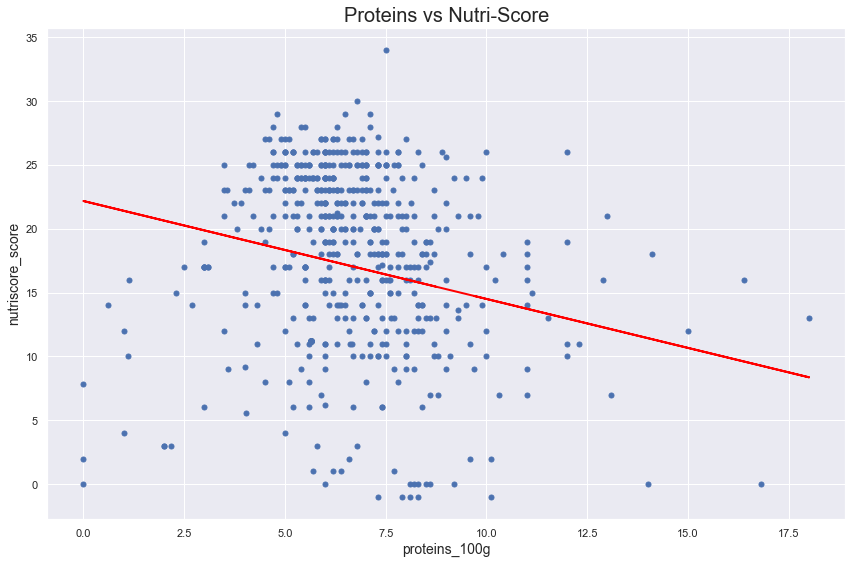

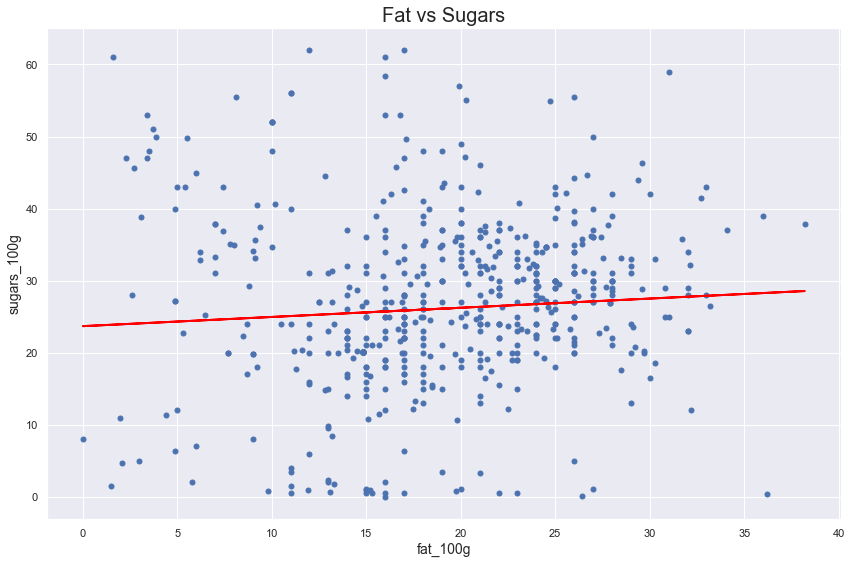

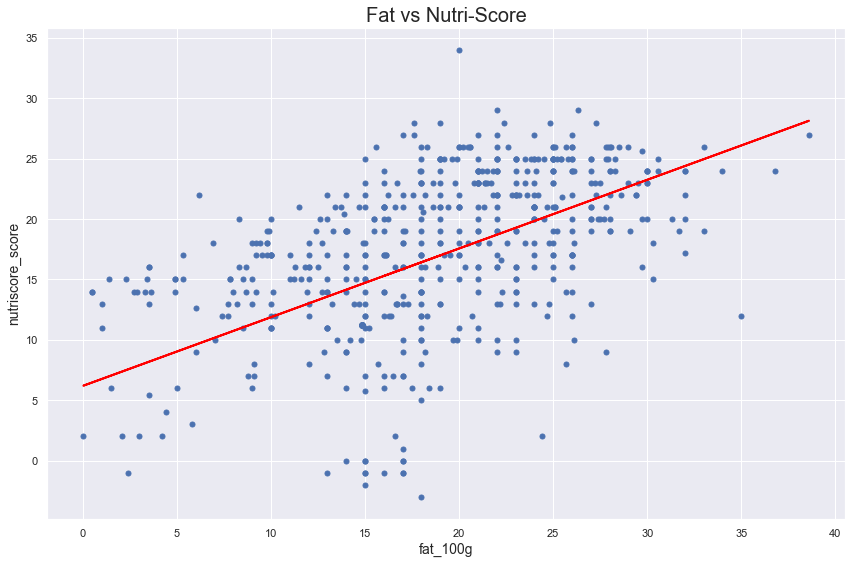

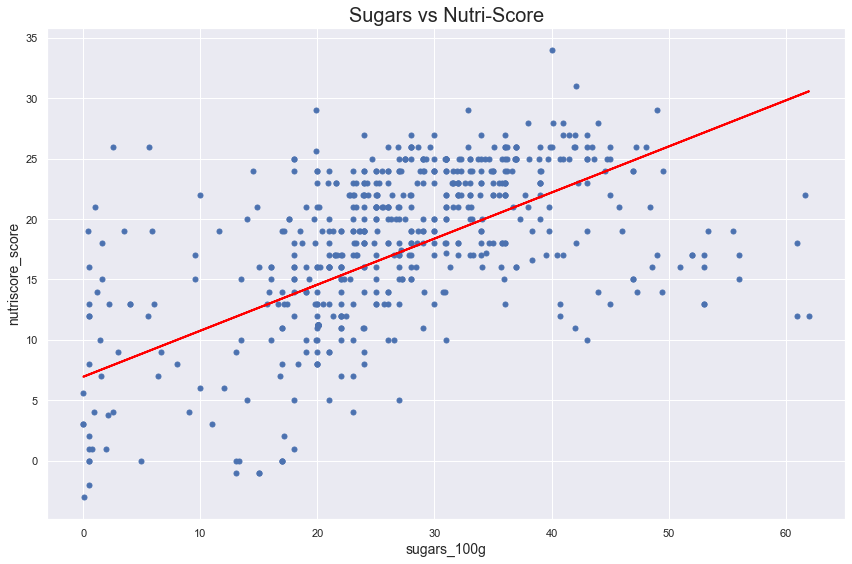

In [142]:
for a, b in itertools.combinations(VARIABLES, 2):
    
    # initializing Linear Regression
    lr = LinearRegression()
    xtrain, xtest, ytrain, ytest = train_test_split(df_subset[[a]], df_subset[[b]], test_size=0.3)
    lr = LinearRegression()
    lr_baseline = lr.fit(xtrain, ytrain)
    pred_baseline = lr_baseline.predict(xtest)
    
    # PLotting the graph
    plt.figure(figsize=(12,8))
    ax = plt.gca()
    ax.set_title(VARIABLES.get(a) + " vs " + VARIABLES.get(b), size=20)
    plt.plot(xtest, ytest, 'bo', markersize = 5)
    plt.plot(xtest, pred_baseline, color="red", linewidth = 2)
    plt.xlabel(a, size=14)
    plt.ylabel(b, size=14)
    plt.tight_layout()
    plt.savefig("img/correlation-" + VARIABLES.get(a) + "-vs-" + VARIABLES.get(b) + ".png")
    plt.show()

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.1.1 Correlation Matrix</h4>
</div>

<div class="alert alert-block alert-info">
    Calculating the <b>correlation</b> between the features through <b>Pearson</b>
</div>

In [153]:
df_subset_correlation = pd.DataFrame(df_subset, columns=VARIABLES.keys())

In [158]:
df_correlation_matrix = pd.DataFrame(df_subset_correlation.corr())

In [160]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

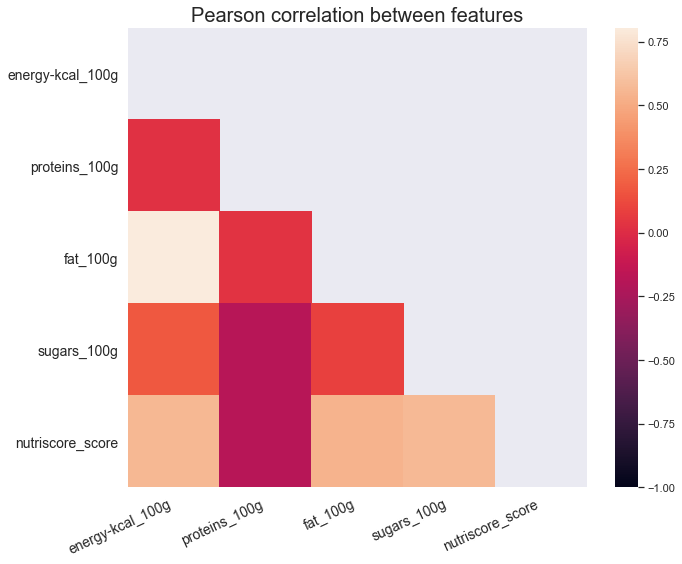

In [168]:
plt.figure(figsize=(10,8))
plt.title("Pearson correlation between features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1)
plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/Pearson correlation between features.png")
plt.show()

<div class="alert alert-block alert-danger">
    <b>Flag position</b>
</div>

<div class="alert alert-block alert-info">
    This <b>notebook</b> is optimized to <b>be used</b> with:
    <ul style="list-style-type: square;">
        <li>Analisis bivariable</li>
        <li>Anova</li>
    </ul>
</div>